<a href="https://colab.research.google.com/github/sashwinbwaj/Customer-Segmentation-Dashboard/blob/main/FIFA_22_Player_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.0 Loading & Pre-processing



In [ ]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.style as style 

from IPython.display import HTML, display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
player_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIFA_player_data.csv', encoding = "ISO-8859-1")
player_data= player_data.rename(columns = {'FIFA ': 'FIFA'})
#dropping irrelevant columns
columns_to_drop =  ['player_url', 'real_face', 'release_clause_eur', 'player_tags', 'ls', 'st', 'rs', 'lw', 'lf','cf', 'rf', 'rw', 'lam',	'cam',	'ram'	,'lm',	
                    'lcm', 'cm', 'rcm',	'rm',	'lwb',	'ldm',	'cdm',	'rdm',	'rwb',	'lb',	'lcb',	'cb',	'rcb','rb',	'gk',	'player_face_url',	'club_logo_url',	
                    'club_flag_url',	'nation_logo_url',	'nation_flag_url']
player_data = player_data.drop(columns_to_drop, axis = 1)
print(f'Data size : {player_data.shape}')
player_data.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26,82,86,109) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data size : (142079, 75)


,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,FIFA 15,158023,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,1987-06-24,169,67,241.0,FC Barcelona,Spain Primera Division,1.0,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),"Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN
1,FIFA 15,20801,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,1985-02-05,185,80,243.0,Real Madrid CF,Spain Primera Division,1.0,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),"Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN
2,FIFA 15,9014,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,1984-01-23,180,80,21.0,FC Bayern München,German 1. Bundesliga,1.0,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),"Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN


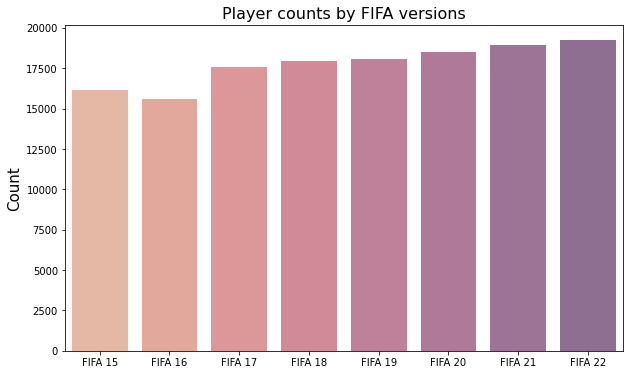

In [ ]:
#Number of player instances from each version of FIFA 
player_data.FIFA.value_counts()
from IPython.display import HTML, display

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fig, ax = plt.subplots(figsize = (10,6))
plt.title('Player counts by FIFA versions', fontsize=16)
ax = sns.countplot(data = player_data, x = 'FIFA', palette = ('flare'), alpha = 0.7)
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.show()

#### 1.1 Missing value treatment
There are three major reasons for missing values in dataset. 

1.   Missing completely at random: The missing values in the data is completely random in nature, possibly due to non-capture of certain points. It is not localized to certain segment in the population. It assumes that there are no systematic differences between the population with missing values & those without. 
2.   Missing at random (Conditionally missing) : Here, the missing data is not dependant on the column, but instead on certain characterstics of the segment it belongs to. For example, a few questions on depression in a survery recorded more missing values from children as compared to adults. 
3.   Not missing at random: Missing values can occur due to systematic relationship with the unobserved value itself. An example would be when number of transactions on an non-active card would be zero in a payment data. 

I looked at the missing value counts across FIFA versions to start with. Since there were not emanating from a particular year, I looked at a few examples from columns with high missing values to hypothesis reasons for missing data. 



In [ ]:
# Checking the missing counts across each version of FIFA to ascertain if missing values are 
player_data.drop('FIFA', 1).isna().groupby(player_data.FIFA, sort=False).sum().reset_index()

,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,FIFA 15,0,0,0,0,0,0,311,239,0,0,0,0,239,239,239,239,239,239,15243,1151,239,0,0,15074,15074,15074,0,0,0,0,0,0,9556,1775,1775,1775,1775,1775,1775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16155,0,0,0,0,0,0,0,0,14380
1,FIFA 16,0,0,0,0,0,0,233,163,0,0,0,0,171,171,171,171,171,171,14566,1228,171,0,0,14608,14608,14608,0,0,0,0,0,0,8608,1699,1699,1699,1699,1699,1699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15623,0,0,0,0,0,0,0,0,13924
2,FIFA 17,0,0,0,0,0,0,310,224,0,0,0,0,224,224,224,224,224,224,16420,1400,224,0,0,16515,16515,16515,0,0,0,0,0,0,9463,1993,1993,1993,1993,1993,1993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15603
3,FIFA 18,0,0,0,0,0,0,241,236,0,0,0,0,236,236,236,236,236,236,16718,1472,236,0,0,16804,16804,16804,0,0,0,0,0,0,9655,2019,2019,2019,2019,2019,2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15935
4,FIFA 19,0,0,0,0,0,0,241,234,0,0,0,0,234,234,234,234,234,234,17069,1250,234,0,0,16981,16981,16981,0,0,0,0,0,0,10083,2029,2029,2029,2029,2029,2029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16056
5,FIFA 20,0,0,0,0,0,0,250,240,0,0,0,0,240,240,240,625,240,240,17435,1288,240,0,0,17356,17356,17356,0,0,0,0,0,0,10936,2061,2061,2061,2061,2061,2061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16422
6,FIFA 21,0,0,0,0,0,0,237,225,0,0,0,0,225,225,225,225,225,225,18186,983,225,0,0,17817,17817,17817,0,0,0,0,0,0,10629,2083,2083,2083,2083,2083,2083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16861
7,FIFA 22,0,0,0,0,0,0,74,61,0,0,0,0,61,61,61,61,61,61,18137,1163,61,0,0,18480,18480,18480,0,0,0,0,0,0,9841,2132,2132,2132,2132,2132,2132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17107


##### 1.1.1 Missing club information
Club name, division, wage, club position all seem to be correlated based on their missing counts. I look at some of the examples to observe that these are mostly free agents in those FIFA versions. Some exceptions occur such as Oscar Emboaba, but that could be because of the league he plays in. 
So, we will replace these observations with hard-coded separate categories. 

In [ ]:
player_data[player_data['club_name'].isna()].sort_values(by = ['overall', 'FIFA'], ascending = [False, True]).head(5)

,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
49531,FIFA 18,184826,Adrien Silva,Adrien Sebastian Perruchet Silva,"CM, CDM",83,83,NaN,NaN,28,1989-03-15,175,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,Portugal,1354.0,CM,23.0,Right,4,3,3,Medium/High,Normal (170-185),"Flair, Long Shot Taker (AI)",65.0,76.0,82.0,81.0,78.0,72.0,78,71,61,83,75,82,79,75,84,85,64,65,73,77,67,83,56,89,62,80,79,84,75,85,85,82.0,80,78,73,15,6,8,10,7,NaN
49536,FIFA 18,188152,Oscar,Oscar dos Santos Emboaba Júnior,CAM,83,86,NaN,NaN,25,1991-09-09,179,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,Brazil,1370.0,SUB,20.0,Right,3,4,3,Medium/High,Lean (170-185),"Long Shot Taker (AI), Technical Dribbler (AI)",74.0,75.0,79.0,82.0,43.0,47.0,70,75,54,83,63,81,77,77,78,84,75,74,86,81,80,76,66,76,36,77,31,34,81,83,68,83.0,37,50,47,12,10,15,12,12,NaN
122987,FIFA 22,184087,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,NaN
151,FIFA 15,209119,F. Amorebielsa,Francisco Amorebielsa,"CB, LB",82,82,NaN,NaN,28,1985-10-27,194,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,Venezuela,111487.0,LCB,3.0,Left,3,2,3,Medium/High,Lean (185+),"Injury Prone, Dives Into Tackles (AI)",53.0,47.0,56.0,50.0,81.0,85.0,48,38,79,67,53,44,41,34,50,60,53,53,44,73,43,69,68,68,91,41,93,77,49,59,56,NaN,81,84,83,15,5,12,6,12,NaN
49595,FIFA 18,177413,A. Witsel,Axel Witsel,"CM, CDM, CAM",82,82,NaN,NaN,28,1989-01-12,186,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,LCM,6.0,Right,3,4,3,Medium/Medium,Normal (185+),Injury Free,71.0,74.0,77.0,82.0,73.0,80.0,69,71,77,83,67,83,69,68,78,85,67,74,82,81,60,78,72,85,79,74,78,80,75,78,81,86.0,69,73,71,5,7,7,10,7,NaN


##### 1.1.2 Missing National information
While nationality does not have any missing values, similar variables such as National team ID, National team position, jersey all have a very high proportion of missing counts & appears to be random. We will drop these columns.

In [ ]:
player_data[player_data['nation_team_id'].isna()].sort_values(by = ['overall', 'FIFA'], ascending = [False, True]).head(5)

,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
85413,FIFA 20,158023,L. Messi,Lionel Andrés Messi Cuccittini,"RW, CF, ST",94,94,95500000.0,560000.0,32,1987-06-24,170,72,241.0,FC Barcelona,Spain Primera Division,1.0,RW,10.0,NaN,2004-07-01,2021.0,52,Argentina,NaN,NaN,NaN,Left,4,4,5,Medium/Low,Unique,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",87.0,92.0,92.0,96.0,39.0,66.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96.0,33,37,26,6,11,15,14,8,NaN
67333,FIFA 19,177003,L. Modri?,Luka Modri?,"CM, CDM",91,91,67000000.0,425000.0,32,1985-09-09,172,66,243.0,Real Madrid CF,Spain Primera Division,1.0,RCM,10.0,NaN,2012-08-01,2020.0,10,Croatia,NaN,NaN,NaN,Right,4,4,4,High/High,Lean (170-185),"Leadership, Long Passer (AI), Long Shot Taker ...",76.0,76.0,90.0,91.0,70.0,67.0,86,72,55,93,76,90,85,78,88,93,80,72,93,90,94,79,68,89,58,82,62,83,79,92,82,84.0,60,76,73,13,9,7,14,9,NaN
103898,FIFA 21,188545,R. Lewandowski,Robert Lewandowski,ST,91,91,111000000.0,240000.0,31,1988-08-21,184,80,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,NaN,NaN,NaN,Right,4,4,4,High/Medium,Unique,"Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88.0,35,42,19,15,6,12,8,10,NaN
103899,FIFA 21,190871,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,132000000.0,270000.0,28,1992-02-05,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,10.0,NaN,2017-08-03,2022.0,54,Brazil,NaN,NaN,NaN,Right,5,5,5,High/Medium,Unique,"Injury Prone, Flair, Speed Dribbler (AI), Outs...",91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93.0,35,30,29,9,9,15,15,11,NaN
122843,FIFA 22,190871,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,10.0,NaN,2017-08-03,2025.0,54,Brazil,NaN,NaN,NaN,Right,5,5,5,High/Medium,Unique,"Injury Prone, Flair, Speed Dribbler (AI), Play...",91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93.0,35,32,29,9,9,15,15,11,NaN


##### 1.1.3 Missing player attributes
Some of the player attribute variables seems to be missing conditionally as well. A quick look ensured that we were looking at completely outfield attributes such as defending, pace missing for GK. Same trends is observed for outfield players with respect to goalkeeping attributes.   
Instead of fixing them to zero, we can fix them to the average values since that is closer to reality. The density plots of the traits almost follows a normal distribution with average in 60-70 range.  

In [ ]:
player_data[player_data['pace'].isna()].sort_values(by = ['overall', 'FIFA'], ascending = [False, True]).sample(n = 10)

,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
12767,FIFA 15,211033,L. García,Luis Manuel García Palomera,GK,58,68,100000.0,2000.0,21,1992-12-31,183,84,110150.0,Gallos Blancos de Querétaro,Mexican Liga MX,1.0,RES,22.0,NaN,2013-07-01,2020.0,83,Mexico,NaN,NaN,NaN,Right,3,1,1,Medium/Medium,Normal (170-185),NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,25,25,30,25,25,25,25,23,22,46,49,32,51,55,21,57,29,71,25,23,23,25,25,22,NaN,25,25,25,63,57,60,57,54,48.0
28854,FIFA 16,213125,D. Twardzik,Daniel Twardzik,GK,59,63,170000.0,3000.0,24,1991-04-13,183,77,83.0,Motherwell,Scottish Premiership,1.0,SUB,12.0,NaN,2014-05-27,2016.0,12,Czech Republic,NaN,NaN,NaN,Right,2,1,1,Medium/Medium,Normal (170-185),NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,18,13,25,15,17,13,13,25,22,44,46,35,56,59,25,54,26,59,16,22,23,12,16,22,NaN,18,20,20,62,54,55,56,66,45.0
56567,FIFA 18,209512,I. Stefanovi?,Igor Stefanovi?,GK,68,68,600000.0,6000.0,29,1987-07-17,192,86,1867.0,Córdoba CF,Spanish Segunda División,2.0,SUB,1.0,NaN,2017-07-26,2019.0,51,Serbia,NaN,NaN,NaN,Right,2,1,1,Medium/Medium,Normal (185+),"Puncher, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,12,17,16,27,13,15,18,21,22,25,49,40,36,64,41,25,59,32,81,13,24,22,18,40,11,24.0,13,13,16,66,68,75,65,68,44.0
140689,FIFA 22,247058,T. Hendriks,Tom Hendriks,GK,55,71,300000.0,600.0,19,2002-05-14,186,76,634.0,Fortuna Sittard,Holland Eredivisie,1.0,RES,41.0,NaN,2018-12-22,2022.0,34,Netherlands,NaN,NaN,NaN,Right,2,1,1,Medium/Medium,Lean (185+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,7,12,18,4,8,11,11,22,13,28,26,32,45,40,40,53,24,50,6,24,7,7,34,14,33.0,5,10,12,56,57,53,56,54,27.0
121309,FIFA 21,256965,J. Eastham,Jordon Eastham,GK,56,75,325000.0,550.0,18,2001-08-08,180,65,3.0,Blackburn Rovers,English League Championship,2.0,RES,45.0,NaN,2020-07-01,2022.0,14,England,NaN,NaN,NaN,Right,3,1,1,Medium/Medium,Normal (170-185),NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,7,10,30,9,12,12,10,28,18,26,20,42,53,42,48,62,25,37,8,28,12,6,39,12,27.0,7,14,13,52,49,64,51,65,23.0
62438,FIFA 18,212087,Álex Guanche,Alexander González Guanche,GK,62,69,325000.0,3000.0,23,1994-01-14,180,69,472.0,Unión Deportiva Las Palmas,Spain Primera Division,1.0,RES,30.0,NaN,2015-07-01,2018.0,45,Spain,NaN,NaN,NaN,Right,3,1,1,Medium/Medium,Lean (170-185),NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,17,15,28,12,13,14,18,24,23,55,59,37,59,66,26,59,45,47,13,27,23,14,17,29,31.0,13,17,16,62,60,50,60,64,57.0
84976,FIFA 19,242145,B. Gradecki,Bart?omiej Gradecki,GK,52,62,60000.0,500.0,18,1999-12-26,194,91,1569.0,Wis?a P?ock,Polish T-Mobile Ekstraklasa,1.0,SUB,28.0,NaN,2017-07-10,2019.0,37,Poland,NaN,NaN,NaN,Right,1,1,1,Medium/Medium,Lean (185+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,8,10,17,7,11,10,12,16,14,30,33,27,41,28,26,36,17,45,9,20,10,8,35,13,43.0,9,12,12,51,55,55,45,55,32.0
84899,FIFA 19,233683,Li Chen,??,GK,52,64,70000.0,1000.0,21,1996-11-25,190,83,112537.0,Beijing Renhe FC,Chinese Super League,1.0,RES,25.0,NaN,2016-01-0

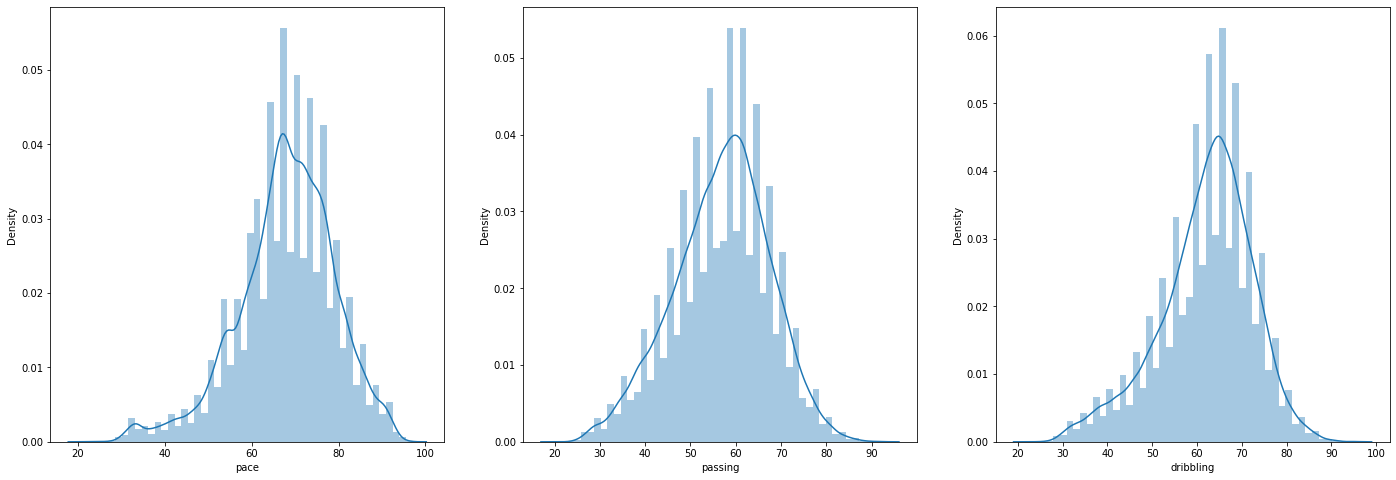

In [ ]:
fig, ax = plt.subplots(figsize = (24, 8))
ax1 = plt.subplot(1, 3, 1)
ax1 = sns.distplot(player_data.pace)
ax2 = plt.subplot(1,3,2)
ax2 = sns.distplot(player_data.passing)
ax3 = plt.subplot(1,3,3)
ax3 = sns.distplot(player_data.dribbling)
plt.show()

In [ ]:
player_data_new.columns

Index(['FIFA', 'sofifa_id', 'short_name', 'long_name', 'player_positions',
       'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob',
       'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_name',
       'league_level', 'club_position', 'club_jersey_number',
       'club_loaned_from', 'club_joined', 'club_contract_valid_until',
       'nationality_id', 'nationality_name', 'preferred_foot', 'weak_foot',
       'skill_moves', 'international_reputation', 'work_rate', 'body_type',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping',

#### 1.1.5 Missing value treatment

In [ ]:
drop_cols = ['nation_team_id', 'nation_position', 'nation_jersey_number', 'player_traits', 'mentality_composure', 'goalkeeping_speed']
player_data_new = player_data.drop(drop_cols, 1)

# Filling free agent data
player_data_new['club_team_id'] = player_data_new['club_team_id'].fillna(0).astype('int64')
player_data_new['club_name'] = player_data_new['club_name'].fillna('Free Agent')
player_data_new['league_name'] = player_data_new['league_name'].fillna('Free Agent')
player_data_new['league_level'] = player_data_new['league_level'].fillna(0).astype('int64')
player_data_new['club_position'] = player_data_new['club_position'].fillna('Free Agent')
player_data_new['club_jersey_number'] = player_data_new['club_jersey_number'].fillna(0).astype('int64')
player_data_new['wage_eur'] = player_data_new['wage_eur'].fillna(0).astype('int64')
player_data_new['value_eur'] = player_data_new['value_eur'].fillna(0).astype('int64')

# Filling loaned player data
player_data_new['club_loaned_from'] = player_data_new['club_loaned_from'].fillna('Not Loan')
player_data_new['club_joined'] = player_data_new['club_joined'].fillna('Not Loan')
player_data_new['club_contract_valid_until'] = player_data_new['club_contract_valid_until'].fillna(2015).astype('int64')
player_data_new['main_position'] = player_data_new['player_positions'].str.split(',').str[0]

# Aggregating attributes
player_data_new['attacking'] = ((player_data_new['attacking_crossing'] + player_data_new['attacking_finishing'] + player_data_new['attacking_heading_accuracy'] + player_data_new['attacking_short_passing'] + player_data_new['attacking_volleys'])/5).astype('int64')
player_data_new['skill'] = ((player_data_new['skill_dribbling'] + player_data_new['skill_curve'] + player_data_new['skill_fk_accuracy'] + player_data_new['skill_long_passing'] + player_data_new['skill_ball_control'])/5).astype('int64')
player_data_new['movement'] = ((player_data_new['movement_acceleration'] + player_data_new['movement_sprint_speed'] + player_data_new['movement_agility'] + player_data_new['movement_reactions'] + player_data_new['movement_balance'])/5).astype('int64')
player_data_new['power'] = ((player_data_new['power_shot_power'] + player_data_new['power_jumping'] + player_data_new['power_stamina'] + player_data_new['power_strength'] + player_data_new['power_long_shots'])/5).astype('int64')
player_data_new['mentality'] = ((player_data_new['mentality_aggression'] + player_data_new['mentality_interceptions'] + player_data_new['mentality_positioning'] + player_data_new['mentality_vision'] + player_data_new['mentality_penalties'])/5).astype('int64')
player_data_new['defense'] = ((player_data_new['defending_sliding_tackle'] + player_data_new['defending_standing_tackle'] + player_data_new['defending_marking_awareness'])/3).astype('int64')


average_impute_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
for cols in average_impute_cols:
    player_data_new[cols] = player_data_new[cols].fillna(player_data_new[cols].mean()).astype('int64')
    
player_data_new.columns = ['FIFA', 'sofifa_id', 'short_name', 'long_name', 'player_positions',
       'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob',
       'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_name',
       'league_level', 'club_position', 'club_jersey_number',
       'club_loaned_from', 'club_joined', 'club_contract_valid_until',
       'nationality_id', 'nationality_name', 'preferred_foot', 'weak_foot',
       'skill_moves', 'international_reputation', 'work_rate', 'body_type',
       'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'crossing', 'finishing',
       'heading_accuracy', 'short_passing',
       'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control',
       'acceleration', 'sprint_speed', 'agility',
       'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions',
       'positioning', 'vision', 'penalties',
       'marking_awareness', 'standing_tackle',
       'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes', 'main_position', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defense']

player_data_new.isna().sum()

FIFA                         0
sofifa_id                    0
short_name                   0
long_name                    0
player_positions             0
overall                      0
potential                    0
value_eur                    0
wage_eur                     0
age                          0
dob                          0
height_cm                    0
weight_kg                    0
club_team_id                 0
club_name                    0
league_name                  0
league_level                 0
club_position                0
club_jersey_number           0
club_loaned_from             0
club_joined                  0
club_contract_valid_until    0
nationality_id               0
nationality_name             0
preferred_foot               0
weak_foot                    0
skill_moves                  0
international_reputation     0
work_rate                    0
body_type                    0
pace                         0
shooting                     0
passing 

In [ ]:
# Let us look at some club data
def club_data(year, club, type):
  if type == 'Starting 11':
    club_data = player_data_new[(player_data_new['club_name'] == club) & (~player_data_new['club_position'].isin(['SUB', 'RES'])) & (player_data_new['FIFA'] == year)]
  else:
    club_data = player_data_new[(player_data_new['club_name'] == club) & (player_data_new['FIFA'] == year)]
  print(f'Team Roaster : {club}')
  return club_data[['short_name', 'club_position', 'club_jersey_number', 'age', 'wage_eur', 'club_contract_valid_until', 'overall', 'potential']].sort_values(by = 'club_jersey_number')

In [ ]:
club_data('FIFA 22', 'Chelsea', 'Starting 11')

Team Roaster : Chelsea


,short_name,club_position,club_jersey_number,age,wage_eur,club_contract_valid_until,overall,potential
123010,A. Rüdiger,LCB,2,28,130000,2022,83,84
123379,Marcos Alonso,LWB,3,30,95000,2023,79,79
123292,A. Christensen,CB,4,25,95000,2022,80,85
122928,Jorginho,LCM,5,29,170000,2023,85,85
122850,N. Kanté,RCM,7,30,230000,2023,90,90
122865,R. Lukaku,ST,9,28,260000,2026,88,88
123099,C. Pulisic,LW,10,22,120000,2024,82,88
123034,É. Mendy,GK,16,29,105000,2025,83,85
123033,M. Mount,RW,19,22,120000,2024,83,89
123219,R. James,RCB,24,21,76000,2025,81,86


### 2.1 Exploratory Analysis

In [ ]:
# Taking only the FIFA 22 data for EDA & Modelling purposes
fifa22_players = player_data_new[player_data_new['FIFA'] == 'FIFA 22']
fifa22_players.shape

(19239, 76)

#### 2.1.1 Player counts across top-division leagues

In [ ]:
# defining a function which plots values in a seaborn bar plot
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

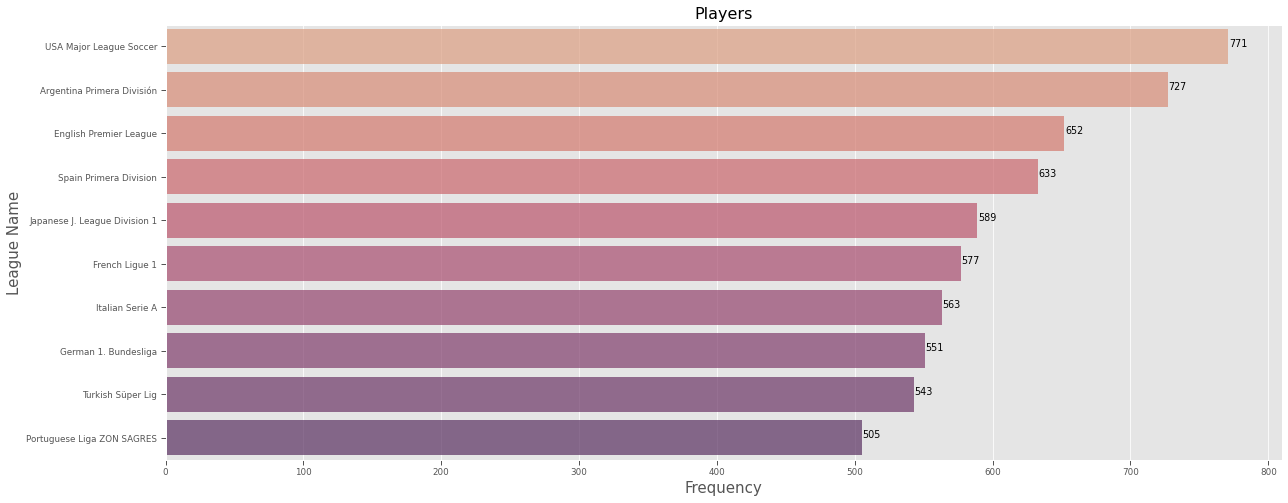

In [ ]:
league_counts = pd.DataFrame(fifa22_players[fifa22_players.league_level == 1].groupby('league_name').count()).reset_index()[['league_name', 'sofifa_id']].sort_values(by = 'sofifa_id', ascending = False)
league_counts = league_counts.nlargest(10, 'sofifa_id')
fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Players', fontsize=16)
ax = sns.barplot(x = league_counts['sofifa_id'], y = league_counts['league_name'], palette = ('flare'), alpha = 0.7)
ax.set_xlabel('Frequency', fontsize = 15)
ax.set_ylabel('League Name', fontsize = 15)
show_values(ax, "h", space=0.5)
plt.show()

#### 2.1.2 Player position counts 

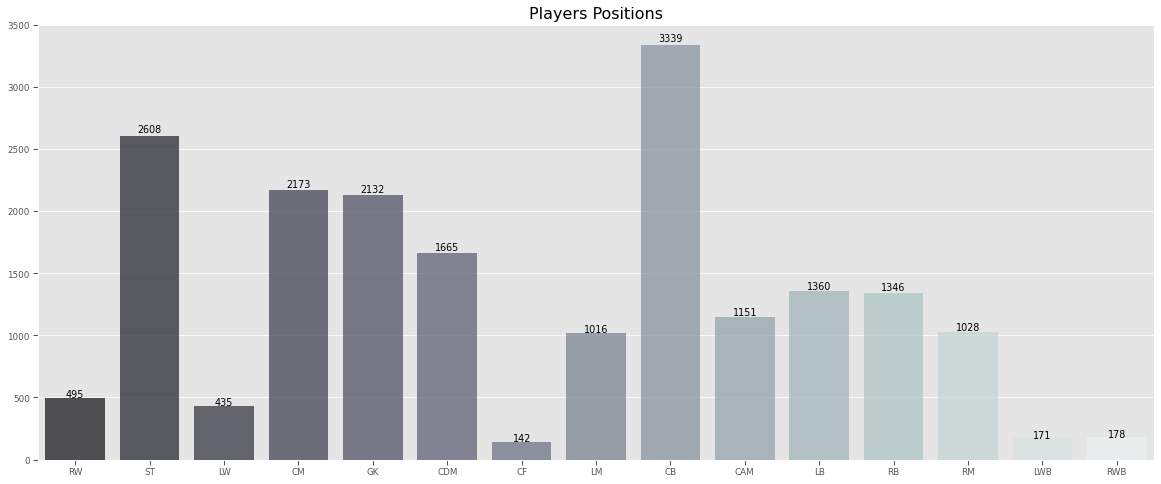

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))


fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Players Positions', fontsize=16)
ax = sns.countplot(data = fifa22_players, x = 'main_position', palette = ('bone'), alpha = 0.7)
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
show_values(ax, space=0.5)
plt.show()

#### 2.1.3 Who are the best players in each top divisions? Do we have a monopoly in player talents in a league?

In [ ]:
def get_top10(year, league):
  league_data = player_data_new[(player_data_new['league_name'] == league) & (player_data_new['FIFA'] == year)].nlargest(10, 'overall')
  return league_data

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0, flags=flags)


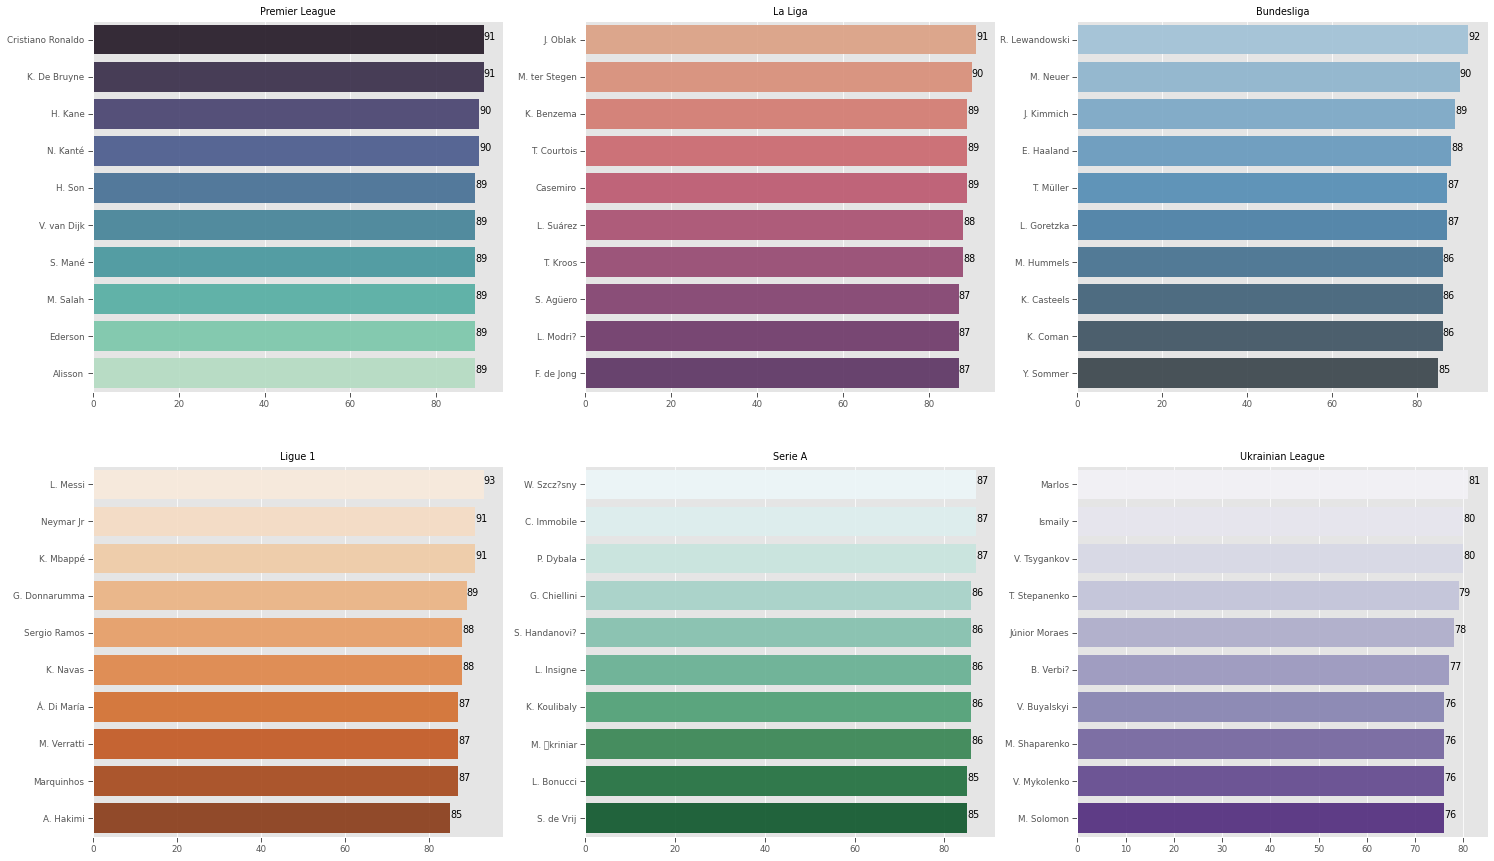

In [ ]:
fig, ax = plt.subplots(figsize = (25,15))
ax1 = plt.subplot(2,3,1)
ax1 = sns.barplot(data = get_top10('FIFA 22' ,'English Premier League'), y = 'short_name', x = 'overall', palette=('mako'), alpha = 0.9)
ax1.set_title('Premier League')
ax1.set_xlabel('')
ax1.set_ylabel('')
show_values(ax1, orient = 'h')

ax2 = plt.subplot(2,3,2)
ax2 = sns.barplot(data = get_top10('FIFA 22' ,'Spain Primera Division'), y = 'short_name', x = 'overall', palette=('flare'), alpha = 0.9)
ax2.set_title('La Liga')
ax2.set_xlabel('')
ax2.set_ylabel('')
show_values(ax2, orient = 'h')

ax3 = plt.subplot(2,3,3)
ax3 = sns.barplot(data = get_top10('FIFA 22' ,'German 1. Bundesliga'), y = 'short_name', x = 'overall', palette=('Blues_d'), alpha = 0.9)
ax3.set_title('Bundesliga')
ax3.set_xlabel('')
ax3.set_ylabel('')
show_values(ax3, orient = 'h')

ax1 = plt.subplot(2,3,4)
ax1 = sns.barplot(data = get_top10('FIFA 22' ,'French Ligue 1'), y = 'short_name', x = 'overall', palette=('Oranges'), alpha = 0.9)
ax1.set_title('Ligue 1')
ax1.set_xlabel('')
ax1.set_ylabel('')
show_values(ax1, orient = 'h')

ax2 = plt.subplot(2,3,5)
ax2 = sns.barplot(data = get_top10('FIFA 22' ,'Italian Serie A'), y = 'short_name', x = 'overall', palette=('BuGn'), alpha = 0.9)
ax2.set_title('Serie A')
ax2.set_xlabel('')
ax2.set_ylabel('')
show_values(ax2, orient = 'h')

ax3 = plt.subplot(2,3,6)
ax3 = sns.barplot(data = get_top10('FIFA 22' ,'Ukrainian Premier League'), y = 'short_name', x = 'overall', palette=('Purples'), alpha = 0.9)
ax3.set_title('Ukrainian League')
ax3.set_xlabel('')
ax3.set_ylabel('')
show_values(ax3, orient = 'h')


*   Premier League has representations from 5 clubs (Manchester City, Spurs, Chelsea, United & Liverpool) with the highest coming from Liverpool
*   Bayern has a dominant representation in Bundesliga with 7 sevens making it to the top 10. Haaland is joined by two shotstoppers from Wolfsburg & M'Gladbach
*   Talk about dominance! The top 10 players of Ligue 1 all come from PSG. Quite competitive eh? 





#### 2.1.4 Weak foot ratings 

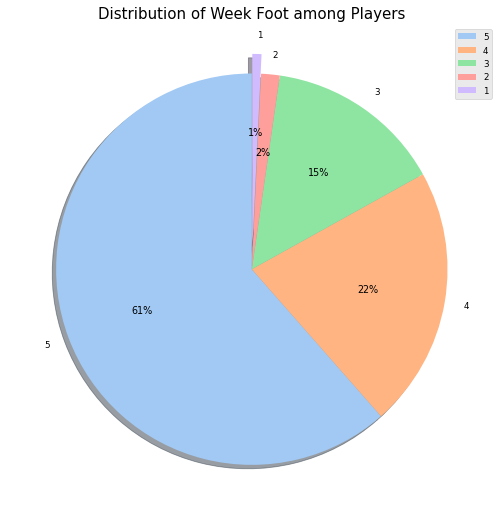

In [ ]:
# plotting a pie chart to represent the share of week foot players
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

#define data
plt.subplots(figsize = (9,9))
labels = ['5', '4', '3', '2', '1'] 
size = fifa22_players['weak_foot'].value_counts()
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
explode = [0, 0, 0, 0, 0.1]
#create pie chart
plt.pie(size, labels = labels, colors = colors, explode = explode, autopct='%.0f%%', shadow = True, startangle = 90)
plt.title('Distribution of Week Foot among Players', fontsize = 15)
plt.legend(loc = 'best')
plt.show()

#### 2.1.5 Who are the best footballers in each position?

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

fifa22_players.loc[fifa22_players.groupby(fifa22_players['main_position'])['overall'].idxmax()].reset_index()[['main_position', 'short_name', 'age', 'club_name', 'overall', 'wage_eur', 'value_eur']].style.background_gradient(cmap='YlOrRd', subset=['age', 'value_eur'])

,main_position,short_name,age,club_name,overall,wage_eur,value_eur
0,CAM,Bruno Fernandes,26,Manchester United,88,250000,107500000
1,CB,V. van Dijk,29,Liverpool,89,230000,86000000
2,CDM,N. Kanté,30,Chelsea,90,230000,100000000
3,CF,K. Benzema,33,Real Madrid CF,89,350000,66000000
4,CM,K. De Bruyne,30,Manchester City,91,350000,125500000
5,GK,J. Oblak,28,Atlético de Madrid,91,130000,112000000
6,LB,A. Robertson,27,Liverpool,87,175000,83500000
7,LM,H. Son,28,Tottenham Hotspur,89,220000,104000000
8,LW,Neymar Jr,29,Paris Saint-Germain,91,270000,129000000
9,LWB,L. Spinazzola,28,Roma,83,72000,33000000


#### 2.1.6 How does overall relate with Age? Do we notice anything across player positions?

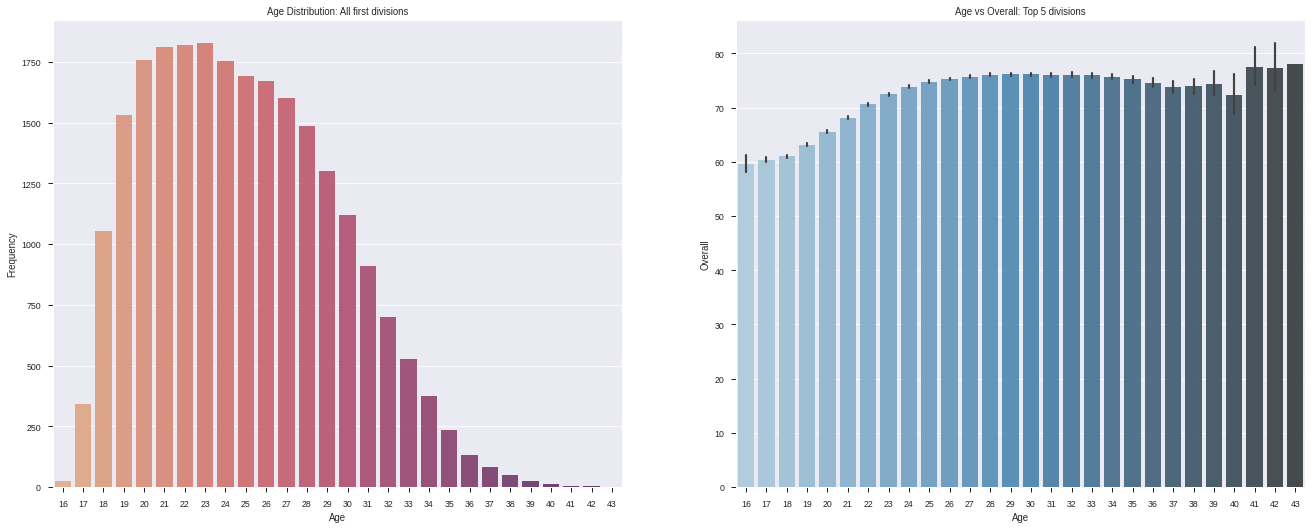

In [ ]:
#age_average_data = pd.DataFrame(fifa22_players[fifa22_players.league_level == 1].groupby('age').mean()).reset_index()[['age', 'overall', 'potential']]
style.use('seaborn')
sns.set_context('paper')

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

league_list = ['English Premier League', 'Italian Serie A', 'Spain Primera Division', 'German 1. Bundesliga', 'French Ligue 1']
top_5_leagues = player_data_new[player_data_new.league_name.isin(league_list)]
fig, ax = plt.subplots(figsize = (20,8))
ax1 = plt.subplot(1,2,1)
ax1 = sns.countplot(data = top_5_leagues , x = 'age', palette = ('flare'), alpha = 0.9)
ax1.set_title('Age Distribution: All first divisions')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')

ax2 = plt.subplot(1,2,2)
ax2 = sns.barplot(data = top_5_leagues, x = 'age', y = 'overall', palette = ('Blues_d'), alpha = 0.9)
ax2.set_title('Age vs Overall: Top 5 divisions')
ax2.set_xlabel('Age')
ax2.set_ylabel('Overall')
plt.show()


We see that the number of players are very less when the age is below 17 or above 34. Player overall seems to be increasing till 29 before dropping only for a couple more years. My initial hunch is the presence of outliers (world's best players currently in 30-34 years bracket).   
To observe any meaningful trend, we can look at 18-34 across different positions across all leagues & FIFA versions.

In [ ]:
top_5_leagues = top_5_leagues[(top_5_leagues['age'] > 16) & (top_5_leagues['age'] < 36)]
def define_roles(pos):
  if pos in ['ST', 'CF', 'LW', 'RW', 'LM', 'RM']:
    return 'Attacking'
  elif pos in ['CAM', 'CM', 'CDM', 'LWB', 'RWB']:
    return 'Midfield'
  elif pos in ['GK']:
    return 'Goalkeeping'
  else:
     return 'Defense'

top_5_leagues['Role'] = top_5_leagues.apply(lambda row : define_roles(row['main_position']), axis = 1)

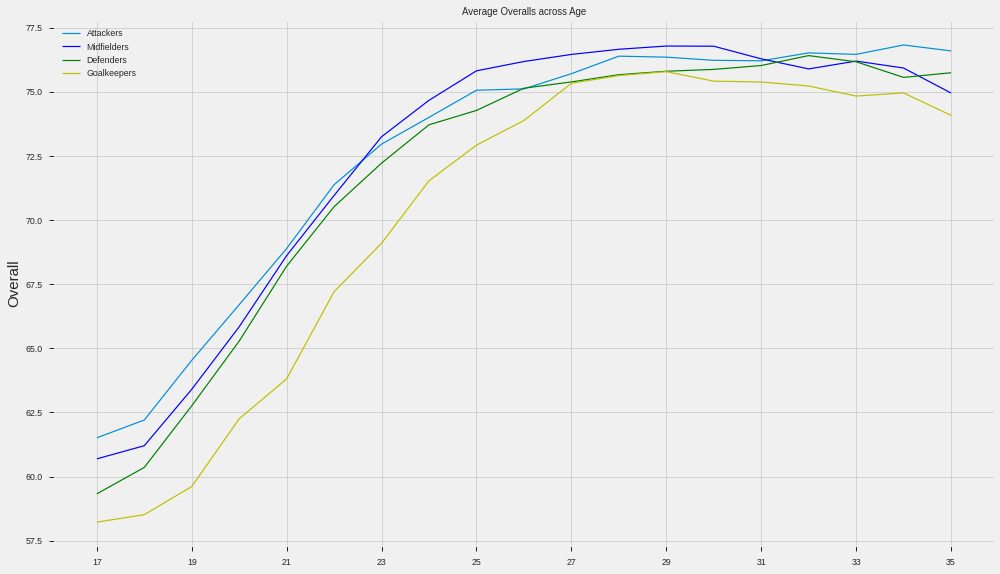

In [ ]:
style.use('fivethirtyeight')
sns.set_context('paper')

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

attacking_summ = top_5_leagues[top_5_leagues['Role'] == 'Attacking'].groupby(by = 'age')['overall'].mean().reset_index()
midfield_summ = top_5_leagues[top_5_leagues['Role'] == 'Midfield'].groupby(by = 'age')['overall'].mean().reset_index()
defense_summ = top_5_leagues[top_5_leagues['Role'] == 'Defense'].groupby(by = 'age')['overall'].mean().reset_index()
goalkeeping_summ = top_5_leagues[top_5_leagues['Role'] == 'Goalkeeping'].groupby(by = 'age')['overall'].mean().reset_index()

fig, ax = plt.subplots(figsize = (15, 9))
plt.title('Average Overalls across Age', fontsize = 15)
plt.plot(attacking_summ.age, attacking_summ.overall, label = 'Attackers')
plt.ylabel('Overall', fontsize = 15)
plt.plot(midfield_summ.age, midfield_summ.overall, 'b-', label = 'Midfielders')
plt.plot(defense_summ.age, defense_summ.overall, 'g-', label = 'Defenders')
plt.plot(goalkeeping_summ.age, goalkeeping_summ.overall,  'y-', label = 'Goalkeepers')
plt.xticks(np.arange(min(attacking_summ.age), max(attacking_summ.age)+1, 2.0))
plt.legend(loc = 'best')
plt.show()

I noticed a bunch of slight variations in how overall varies with age

1.   Attackers & Midfielders start with a much higher overall at a young age (gap between the blue lines & the yellow line) as compared to goalkeepers.
2.   Midfielder's overall keeps increasing till around 30 before starting to deterioate. Goalkeepers follow a similar trend, although their average overall is considerably lower than midfielders. 
3.   Attackers reach their prime around 28-30, but tend to stablize & stay there without a big drop.

Note that the insights of how player talents change with age is flawed in this scenario, since an ideal approach would be to track the individual journeys of all players from ages 16-35. Further, outliers are likely to govern the deviations for older players (For example: Ronaldo is 92 at the age of 34 in FIFA 21) 



#### 2.17 How does the player attributes vary with each leagues?
Is Italian football reliant on defending? Are LaLiga matches more technical?
Is PL aggresive?

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

league_list = ['English Premier League', 'Italian Serie A', 'Spain Primera Division', 'German 1. Bundesliga', 'French Ligue 1']
league_comparison_data = fifa22_players[fifa22_players.league_name.isin(league_list)][['league_name', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defense']]
league_comparison_summ = league_comparison_data.groupby('league_name').mean()

import plotly.graph_objects as go

categories = ['attacking', 'skill', 'movement', 'power', 'mentality', 'defense']

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=league_comparison_summ[league_comparison_summ.index == 'English Premier League'].values.flatten().tolist(),
      theta=categories,
      fill='toself',
      name='EPL'
))
fig.add_trace(go.Scatterpolar(
      r=league_comparison_summ[league_comparison_summ.index == 'Italian Serie A'].values.flatten().tolist(),
      theta=categories,
      fill='toself',
      name='Serie A'
))
fig.add_trace(go.Scatterpolar(
      r=league_comparison_summ[league_comparison_summ.index == 'Spain Primera Division'].values.flatten().tolist(),
      theta=categories,
      fill='toself',
      name='LaLiga'
))
fig.add_trace(go.Scatterpolar(
      r=league_comparison_summ[league_comparison_summ.index == 'German 1. Bundesliga'].values.flatten().tolist(),
      theta=categories,
      fill='toself',
      name='Bundesliga'
))
fig.add_trace(go.Scatterpolar(
      r=league_comparison_summ[league_comparison_summ.index == 'French Ligue 1'].values.flatten().tolist(),
      theta=categories,
      fill='toself',
      name='Ligue 1'
))

fig.update_layout(
  autosize=False,
    width=750,
    height=750,
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[50, 70]
    )),
  showlegend=True
)

fig.show()

There is not a huge difference between the attribute summaries of different leagues, but we notice some subtle trends.

*   Defending stats for Serie A players are higher than any other league
*   EPL leads the way for movement, which includes attributes such as sprint speed, acceleration, agility etc
*   LaLiga has the highest average when it comes to technical skills & power. This is quite obvious by their intricate passing style play.

### 3.1 Effect of variables on wage
 

##### 3.1.1 How does player wage distribution look like? Does PL overpay their players?  
Let's start by looking at how wages are distributed & its relationship with age & overall. 

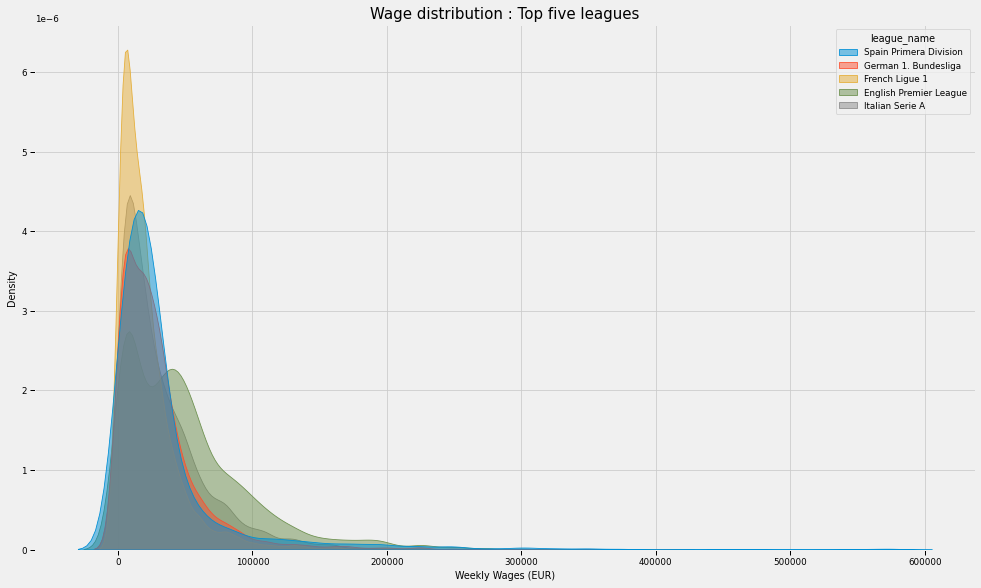

In [ ]:
style.use('fivethirtyeight')
sns.set_context('paper')


display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

league_list = ['English Premier League', 'Italian Serie A', 'Spain Primera Division', 'German 1. Bundesliga', 'French Ligue 1']
top_5_leagues = player_data_new[player_data_new.league_name.isin(league_list)]
fig, ax = plt.subplots(figsize = (15,9))
ax1 = sns.kdeplot(data = top_5_leagues, x = 'wage_eur', hue = "league_name", shade=True, alpha = 0.5)
ax1.set_title('Wage distribution : Top five leagues', fontsize = 15)
ax1.set_xlabel('Weekly Wages (EUR)')
plt.show()

Ligue 1 is much more right skewed than the rest while Premier League is bimodal in nature with a much fatter right tail, suggesting a higher wage culture than the rest of the leagues. But, this could maybe result from the talent levels found in these leagues. Let us double click on Ligue 1 & Premier League by looking at the distribution of talents (overall, potential etc)

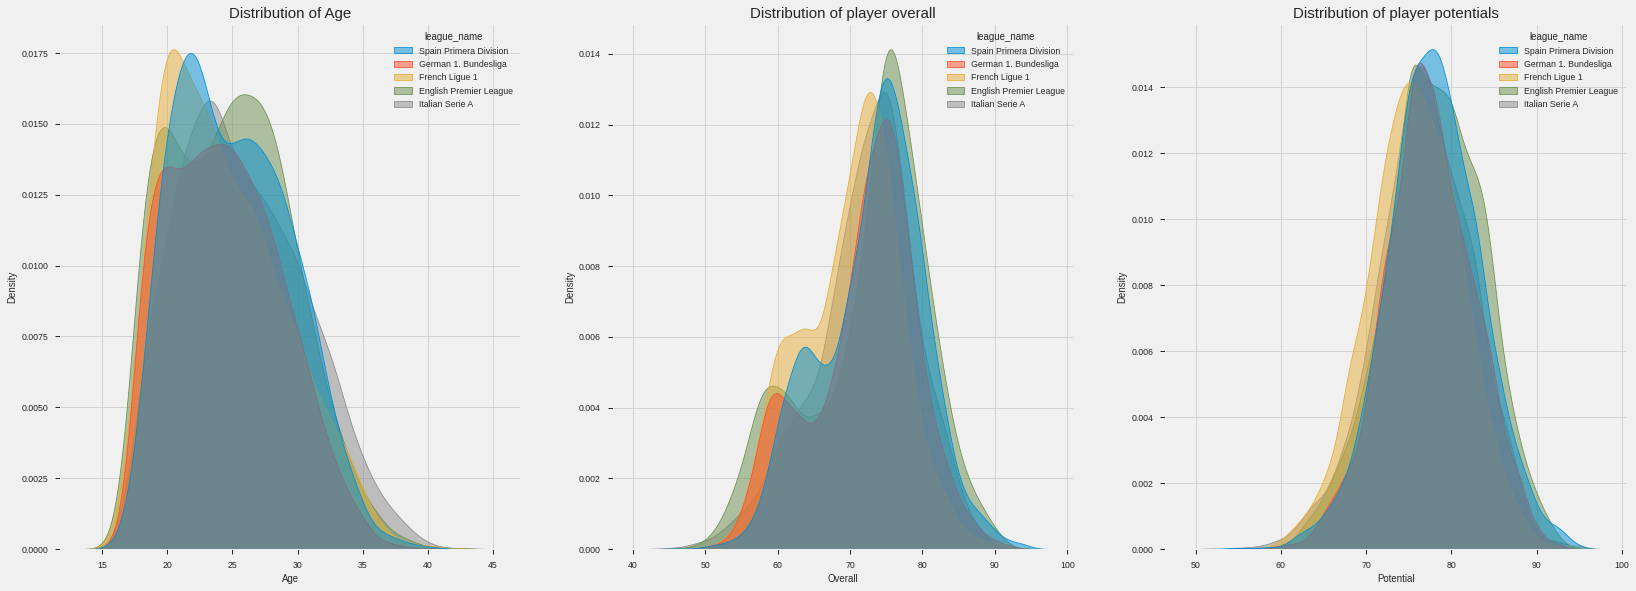

In [ ]:
style.use('fivethirtyeight')
sns.set_context('paper')

fig, ax = plt.subplots(figsize = (25,9))
plt.subplot(1,3,1)
ax1 = sns.kdeplot(data = top_5_leagues, x = 'age', hue = "league_name", shade=True, alpha=.5)
ax1.set_title('Distribution of Age', fontsize = 15)
ax1.set_xlabel('Age')

plt.subplot(1,3,2)
ax1 = sns.kdeplot(data = top_5_leagues, x = 'overall', hue = "league_name", alpha = 0.5, shade=True)
ax1.set_title('Distribution of player overall', fontsize = 15)
ax1.set_xlabel('Overall')

plt.subplot(1,3,3)
ax1 = sns.kdeplot(data = top_5_leagues, x = 'potential', hue = "league_name", alpha = 0.5, shade=True)
ax1.set_title('Distribution of player potentials', fontsize = 15)
ax1.set_xlabel('Potential')

plt.show()

1.   French & Spanish leagues have a slightly greater proportion of young players in their top division while Premier League's peak reaches at a slightly higher age. It is interesting, maybe not surprising to note the fat right tails for the Italian league. More on that later!
2.   Player potential looks more or less normally distributed in all the five leagues
3.   Player overall takes a bimodal curve, with PL having a larger chunk of players with higher overall. It is also interesting to note that the Spanish league has a higher density in the first peak on the left. 




#### 3.1.2 Regressing the effect of League/Overall on Wages

Let us quickly check out a simple linear regression to look at the effect of the league holding player characterstics constant. This will emulate the phenomenon of looking at the wages of similar players in different leagues. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from pandas import get_dummies

# Taking FIFA 22 players for this analysis
top_5_leagues = fifa22_players[fifa22_players.league_name.isin(league_list)]
league_data = top_5_leagues[['league_name']]
league_data_transformed = pd.get_dummies(league_data)
league_data_transformed.columns = ['EPL', 'Ligue1', 'Bundesliga', 'SerieA', 'LaLiga']
league_data_transformed = league_data_transformed.drop('Bundesliga', axis =1)
top_5_leagues = top_5_leagues.drop('league_name', axis = 1)
top_5_leagues_new = pd.concat([top_5_leagues, league_data_transformed], axis = 1)
top_5_leagues_new.head()

,FIFA,sofifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,pace,shooting,passing,dribbling,defending,physic,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking_awareness,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,main_position,attacking,skill,movement,power,mentality,defense,EPL,Ligue1,SerieA,LaLiga
122840,FIFA 22,158023,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000,320000,34,1987-06-24,170,72,73,Paris Saint-Germain,1,RW,30,Not Loan,2021-08-10,2023,52,Argentina,Left,4,4,5,Medium/Low,Unique,85,92,91,95,34,65,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,20,35,24,6,11,15,14,8,RW,85.8,94.0,90.2,77.8,69.4,26.333333,0,1,0,0
122841,FIFA 22,188545,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000,270000,32,1988-08-21,185,81,21,FC Bayern München,1,ST,9,Not Loan,2014-07-01,2023,37,Poland,Right,4,4,5,High/Medium,Unique,78,92,79,86,44,82,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,35,42,19,15,6,12,8,10,ST,86.0,81.4,81.6,84.8,79.2,32.000000,0,0,0,0
122842,FIFA 22,20801,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000,270000,36,1985-02-05,187,83,11,Manchester United,1,ST,7,Not Loan,2021-08-27,2023,38,Portugal,Right,4,5,5,High/Low,Unique,87,94,80,88,34,75,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,24,32,24,7,11,15,14,11,ST,87.6,83.6,85.4,87.2,70.2,26.666667,1,0,0,0
122843,FIFA 22,190871,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000,270000,29,1992-02-05,175,68,73,Paris Saint-Germain,1,LW,10,Not Loan,2017-08-03,2025,54,Brazil,Right,5,5,5,High/Medium,Unique,91,83,86,94,37,63,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,35,32,29,9,9,15,15,11,LW,80.6,89.2,90.2,71.8,73.8,32.000000,0,1,0,0
122844,FIFA 22,192985,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000,350000,30,1991-06-28,181,70,10,Manchester City,1,RCM,17,Not Loan,2015-08-30,2025,7,Belgium,Right,5,4,4,High/High,Unique,76,86,93,88,64,78,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,68,65,53,15,13,5,10,13,CM,81.4,88.0,80.0,81.6,81.4,62.000000,1,0,0,0


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#'attacking' ,'skill' ,'mentality', 'power', 'movement', 'defense',
X = top_5_leagues_new[['overall',  'age', 'EPL', 'Ligue1', 'SerieA', 'LaLiga']]
y = top_5_leagues_new.wage_eur
print(f'X Shape : {X.shape}')
print(f'y Shape : {y.shape}')

model = sm.OLS(y,X)
result = model.fit()
print(result.summary2())

X Shape : (2976, 6)
y Shape : (2976,)
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.513     
Dependent Variable:     wage_eur         AIC:                         70789.2373
Date:                   2022-01-12 00:33 BIC:                         70825.2273
No. Observations:       2976             Log-Likelihood:              -35389.   
Df Model:               6                F-statistic:                 524.4     
Df Residuals:           2970             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.514            Scale:                       1.2505e+09
----------------------------------------------------------------------------------
               Coef.       Std.Err.      t      P>|t|       [0.025        0.975]  
----------------------------------------------------------------------------------
overall        718.3354     62.2384   11.5417   0.0000      596.3007      840.3701
age    

Using major indicators of wages such as player's overall (a combined score of his attributes like pace, power, heading accuracy etc), age & the league he plays in. The biggest contributer to the model is from EPL & Ligue 1, which fits the narrative of similar players in PL having higher wages as compared to Ligue 1 & other leagues. 

### 3.2 Similar players
##### Who are the players most similar to Salah? Who should Liverpool replace him with if he moves to Real Madrid?

Let us look at clustering techniques & use them to find the most similar players.


##### 3.2.1 Understanding how attributes relate to positions

In [ ]:
attribute_vars = fifa22_players.select_dtypes(include=['int64']).drop(['sofifa_id', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 
                                                     'weight_kg', 'club_team_id', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation', 
                                                     'club_jersey_number','club_contract_valid_until', 'nationality_id', 'attacking' ,'skill',
                                                     'mentality', 'power', 'movement', 'defense'], axis = 1).columns.to_list()
def merge_positions(pos):
  if pos in ['ST', 'CF', 'CAM', 'CDM', 'CM', 'CB', 'GK']:
    return pos
  elif pos in ['LW', 'RW' ,'LM', 'RM']:
    return 'WI'
  elif pos in ['LB', 'RB', 'LWB', 'RWB']:
    return 'FB'
  else:
     return 'NA'
fifa22_players['merged_position'] = fifa22_players.apply(lambda row : merge_positions(row['main_position']), axis = 1)
attribute_summary = fifa22_players[fifa22_players.league_level == 1].groupby('merged_position').mean().reset_index()[['merged_position'] + attribute_vars] 
attribute_summary = attribute_summary.set_index('merged_position')                                               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def top_attributes(pos,n):
  highest_values = []
  highest_attributes = []
  df = attribute_summary[attribute_summary.index == pos]
  for i in range(n):
    highest_v = df.max(axis = 1).values[0]
    highest_a = df.idxmax(axis="columns").values[0]
    highest_values.append(highest_v)
    highest_attributes.append(highest_a)
    df = df.drop(highest_a, axis = 1)
  
  summary_table = pd.DataFrame(list(zip(highest_attributes, highest_values)), columns = ['attributes', 'values'])
  return(summary_table)

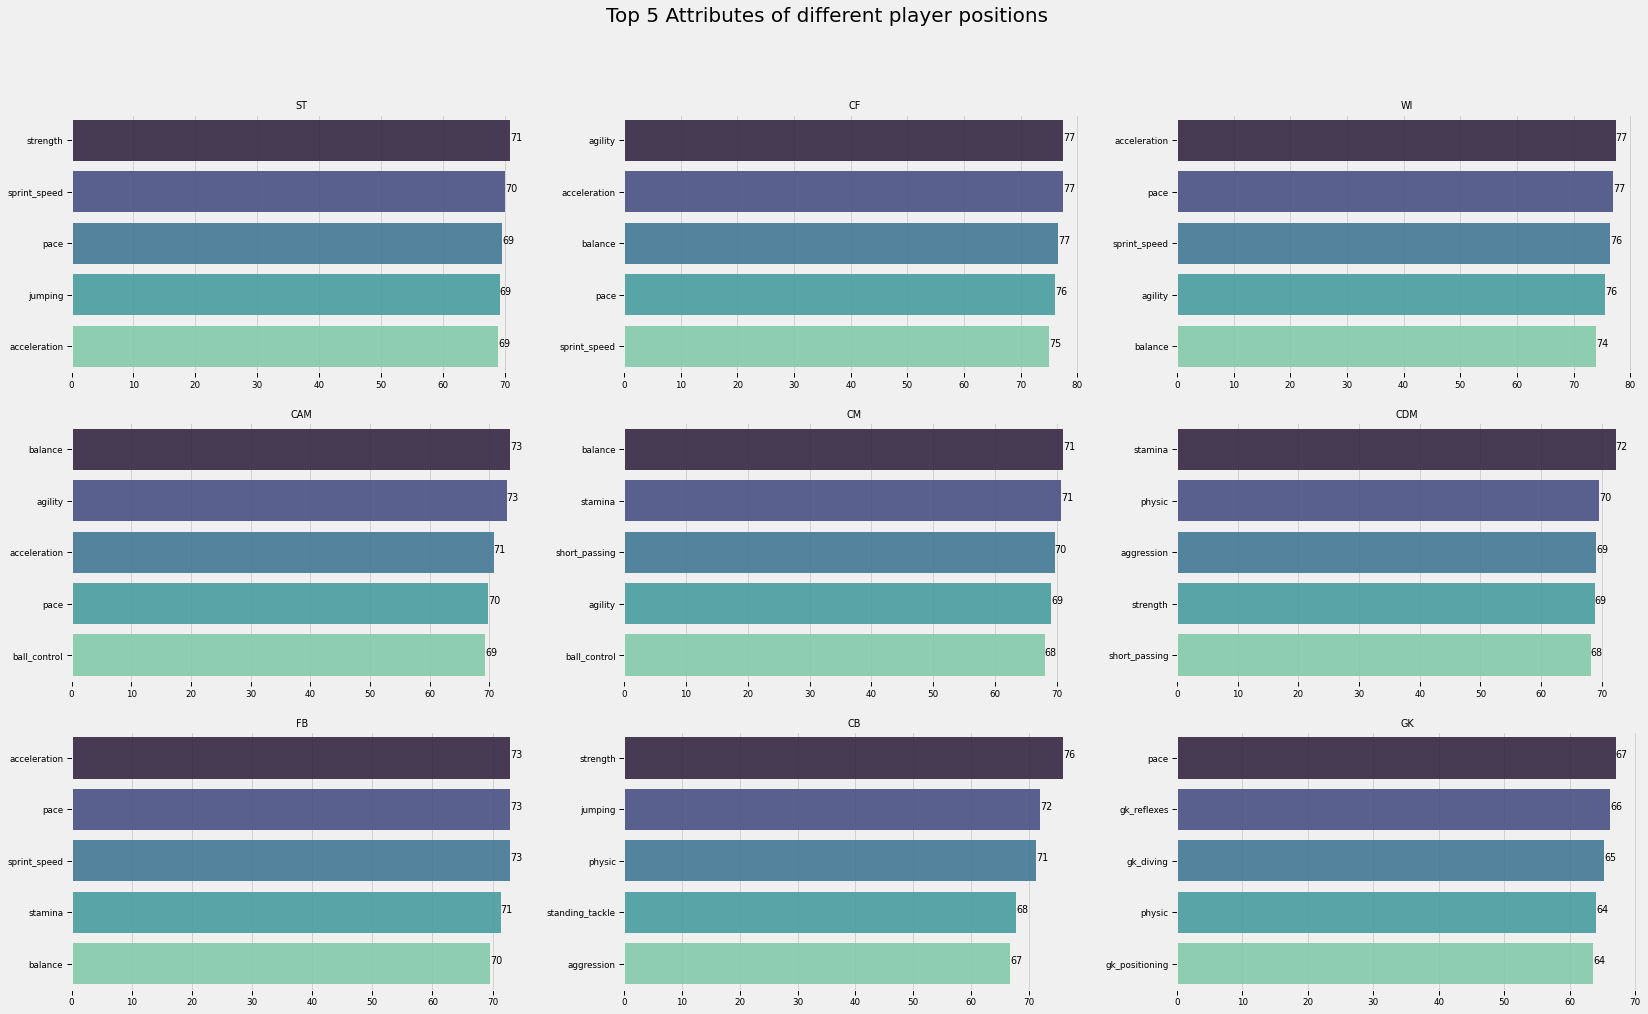

In [ ]:
fig, ax = plt.subplots(figsize = (25,15))
plt.suptitle('Top 5 Attributes of different player positions',fontsize=20)
positions = ['ST', 'CF', 'WI', 'CAM', 'CM', 'CDM', 'FB', 'CB', 'GK']
i = 1
for values in positions:
    ax1 = plt.subplot(3,3,i)
    ax1 = sns.barplot(data = top_attributes(values, 5), y = 'attributes', x = 'values', palette=('mako'), alpha = 0.9)
    ax1.set_title(values)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    show_values(ax1, orient = 'h')
    i = i + 1

plt.show()

#### 3.2.2 Clustering outfield players